# Training an LSTM network on the Penn Tree Bank (PTB) dataset - Part III: TensorFlow graph execution 
---

[1]: http://people.idsia.ch/~juergen/
[2]: http://colah.github.io/posts/2015-08-Understanding-LSTMs/
[3]: https://www.coursera.org/specializations/deep-learning
[4]: http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture10.pdf
[5]: https://arxiv.org/abs/1503.04069
[6]: http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
[7]: https://arxiv.org/abs/1409.2329
[8]: https://www.python.org/
[9]: http://www.numpy.org/
[10]: https://www.tensorflow.org/
[11]: https://www.tensorflow.org/guide/eager
[12]: https://colab.research.google.com/notebooks/welcome.ipynb
[13]: https://www.tensorflow.org/guide/graphs
[14]: https://gist.github.com/karpathy/d4dee566867f8291f086
[15]: https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb
[16]: https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples/rnn_ptb


## Implementing an LSTM network with TensorFlow low-level APIs
The implementation is similar to [this][15] TensorFlow tutorial example, but differs in the following respects:
1. This implementation depends on TensorFlow API that requires an Nvidia GPU to run. The tutorial example switches API depending on whether GPU is available or not, and so can run on either GPU or CPU. 
2. The tutorial example builds separate dataflow graphs for training, evaluation, and testing. This implementation builds only one dataflow graph and uses it for all three purposes.
3. This implementation uses `tf.data.Dataset` for the input pipeline whereas the tutorial predates the Dataset API.

There is only one class, PTBModel, which is responsible for:
1. Building the dataflow graph. The `__init__` method of the PTBModel class builds the dataflow graph. It defines instance atttributes to hold onto those ops/tensors which have to be run at training or evaluation time.
2. Running an epoch of training or evaluation by executing the correct ops/tensors in the graph.



In [0]:
#MIT License - Copyright (c) 2018 tmatha

import tensorflow as tf
import numpy as np
import logging
import time
import math
import datetime
import collections
import matplotlib.pyplot as plt

In [0]:
#MIT License - Copyright (c) 2018 tmatha

class PTBModel(object):
  """
  LSTM network for language modeling for training/evaluation/testing on the PTB
  dataset. Model similar to the TensorFlow tutorial example at
  https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb. The main 
  differences are:
    
  -The tutorial uses tf.contrib.cudnn_rnn.CudnnLSTM when running on Nvidia GPU, 
   and tf.contrib.rnn.BasicLSTMCell or tf.contrib.rnn.LSTMBlockCell when GPU is  
   not available. This model only uses tf.contrib.cudnn_rnn.CudnnLSTM and 
   so Nvidia GPU is always required.
  -The tutorial uses separate computational graphs for training, evaluation and
   testing. This model builds only one computational graph and uses it for 
   all three.
  -This model uses tf.data.Dataset for the input pipe line where as the tutorial
   predates the Dataset API.
  
  Ref: 
    Wojciech Zaremba, Ilya Sutskever, and Oriol Vinyals, 
    "Recurrent Neural Network Regularization", ICLR 2015
    
  Imports:
    tf
    tf.nn
    tf.math
    tf.contrib.cudnn_rnn.CudnnLSTM - requires GPU
    tf.layers.Dense
    tf.train.GradientDescentOptimizer
  
  """
  
  def __init__(
      self, 
      vocab_size, 
      embedding_dim, 
      hidden_dim, 
      num_layers, 
      initializer,
      dropout_ratio, 
      clip_norm,
      learning_rate,
      inp,
      target,
      batch_size):
    """Initalizes a model instance. Creates the nodes (ops) and edges (tensors)
    of the dataflow graph and builds the graph. Data enters the graph via  
    inp and target tensors. Model instance attributes hold references to all ops 
    endpoints which have to be run at training or evaluation time. 
    Kernels, biases and state are stored in tf.Variables.
    
    Args:
      vocab_size: int;
      embedding_dim: int; 
      hidden_dim: int; hidden state size, cell state size
      num_layers: int; number of layers
      initializer: initializer object for initializing kernels and biases
      dropout_ratio: float; drop out ratio
      clip_norm: float; maximum global norm for clipping gradients
      learning_rate: tf.float32, 0-d tensor; 
      inp: input (features) tf.int64 2-d tensor of shape (seq_len,batch_size)
      target: target (labels) tf.int64 2-d tensor of shape (seq_len,batch_size)
      batch_size: int; batch size

    Returns:
      a model instance

    Raises:
      
    """
    
    #create ops and tensors;
    embedding=tf.get_variable(
        'embedding',
        shape=(vocab_size, embedding_dim),
        initializer=initializer,
        trainable=True)
    
    #crashes when input_mode='skip_input' or 'auto_select'
    rnn=tf.contrib.cudnn_rnn.CudnnLSTM(
        num_layers=num_layers, 
        num_units=hidden_dim, 
        dropout=dropout_ratio,
        kernel_initializer=initializer,
        input_mode='linear_input')

    dense=tf.layers.Dense(
        units=vocab_size,        
        kernel_initializer=initializer)
    
    h=tf.get_variable('h',shape=(num_layers,batch_size,hidden_dim),
                     initializer=tf.zeros_initializer,trainable=False)
    c=tf.get_variable('c',shape=(num_layers,batch_size,hidden_dim),
                     initializer=tf.zeros_initializer,trainable=False)
   
    State=collections.namedtuple('State',['h','c'])
    self._state=State(h=h,c=c)
    
    #build dataflow graph connecting the ops nodes with tensor 
    #edges starting with 'inp' and 'target';
    #model instance attributes hold references to the ops endpoints which have 
    #to be run at training or evaluation time;
    y=tf.nn.embedding_lookup(embedding, inp)
    
    #tf.contrib.cudnn_rnn.CudnnLSTM requires input tensor to be of shape 
    #(seq_len,batch_size,embedding_dim), where as tf.keras.layers.CuDNNLSTM 
    #requires input tensor to be of shape (batch_size,seq_len,embedding_dim);
    #see _CudnnRNN(base_layer.Layer).call(self, inputs, initial_state=None, 
    #training=True)
    y,(h,c)=rnn(y, initial_state=self._state, training=True)
    self._update=State(h=self._state.h.assign(h),c=self._state.c.assign(c))
    
    y=dense(y)
    self._loss=tf.math.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits
        (labels=target,logits=y))
    
    optimizer=tf.train.GradientDescentOptimizer(learning_rate)
    grad_var=optimizer.compute_gradients(self._loss)
    gradients,variables=zip(*grad_var)
    clipped, global_norm=tf.clip_by_global_norm(gradients, clip_norm)
    grad_var=zip(clipped, variables)
    self._training_op=optimizer.apply_gradients(grad_var)

  def run_epoch(self, session, steps, is_training=False):
    """Runs an epoch of training or evaluation.
        
    Args:
      session: the session object to run ops
      steps: int; number of steps in an epoch
      is_training: boolean; if True, train; if False, evaluate
      
    Returns:
      A python list of losses, one loss (float) per step
      
    Raises:
    
    """
    session.run({'h':self._state.h.initializer,'c':self._state.c.initializer})
    losses=[]
    fetches={'update':self._update, 'loss':self._loss}
    if is_training:
      fetches['training_op']=self._training_op
    
    for step in range(steps):
      fetched=session.run(fetches)
      losses.append(fetched['loss'])
    return losses

  @classmethod
  def instance(cls, model_type='small', vocab_size=10000, clip_norm=5,
               learning_rate=None, inp=None, target=None):
    """Returns a model instance.
    
    Args:
      model_type: string; 'small', 'medium' or 'large'; only 'small' is
        implemented presently
      vocab_size: int;
      clip_norm: float; maximum global norm for clipping gradients
      learning_rate: tf.float32 0-d tensor
      inp: input (features) tf.int64 2-d tensor of shape (seq_len,batch_size)
      target: target (labels) tf.int64 2-d tensor of shape (seq_len,batch_size)

    Returns:
      a model instance

    Raises:
      
    """
    
    return {
        'small':PTBModel(
            vocab_size=vocab_size,
            embedding_dim=200,
            hidden_dim=200,
            num_layers=2,
            initializer=tf.random_uniform_initializer(minval=-0.1,maxval=0.1),
            dropout_ratio=0.,
            clip_norm=clip_norm,
            learning_rate=learning_rate,
            inp=inp,
            target=target,
            batch_size=20),
        'medium':None,
        'large':None
        }.get(model_type,None)


---

## Data shaping
In language modeling, both input (feature) and target (label) sequences are formed from the same original sequence. The target sequence is simply the input sequence itself advanced by one time step. Both input and target data have to be fed to the model in chunks or mini batches of the requisite shape. The requisite shape differes from API to API; some (e.g. `tf.keras.layers.CuDNNLSTM`) require mini batches of shape (batch size, sequence length), whereas others (e.g. `tf.contrib.cudnn_rnn.CudnnLSTM`) call for mini batches of shape (sequence length, batch size). Here, sequence length is the length of the RNN layer or subsequence, and batch size is the number of subsequences processed together in one step of gradient descent. In other words, gradients are computed and applied for a full mini batch at each step of gradient descent, and it takes "steps" number of mini batches to cover an epoch. If the data doesn't divide cleanly into an integral number of mini batches, the last remaining data is dropped. The following function takes a 1-d data sequence and returns a tuple of input and target arrays to be fed to a Dataset which in turn has to feed correctly-shaped mini batches to the model. The original sequential order is preserved throughout except for having to split the original sequence into the requisite number of subsequences to be processed together. This entails in-memory data array.

In [0]:
#MIT License - Copyright (c) 2018 tmatha

def features_labels(data_array,batch_size,seq_len,batch_first=True):
  """Splits the sequential data into batch_size number of sub_sequences and 
  folds them into the requisite shape. This procedure is applied to the data to 
  derive the features array. This procedure is repeated to derive the labels 
  array also, except in this case the data is shifted by one time step. 
  Returns a named tuple of features and labels.
  
  Args:
    data_array: np.int64 1-d numpy array of shape (size,)
    batch_size: int;
    seq_len: int; length of the rnn layer
    batch_first: boolean; the returned numpy arrays will be of shape 
      (batch_size*steps, seq_len) if True and 
      (seq_len*steps, batch_size) if False
      
  Returns:
    named tuple of features and labels, features and labels are np.int64 2-d 
      numpy arrays of shape (batch_size*steps, seq_len) if batch_first is True 
      and (seq_len*steps, batch_size) if batch_first is False
    steps: int; number of mini batches in an epoch
      
  Raises:
    ValueError: If input data_array is not 1-d

  """
  if len(data_array.shape) != 1:
    raise ValueError('Expected 1-d data array, '
                     'instead data array shape is {} '.format(data_array.shape))
  
  def fold(used_array):
    shaped_array=np.reshape(used_array,(batch_size,seq_len*steps),order='C')
    
    if batch_first:
      return np.concatenate(np.split(shaped_array,steps,axis=1),axis=0)
    else:
      return np.transpose(shaped_array)

  steps=(data_array.shape[0]-1)//(batch_size*seq_len)
  used=batch_size*seq_len*steps
  
  features=fold(data_array[:used])
  labels=fold(data_array[1:used+1])
  
  Data=collections.namedtuple('Data',['features','labels'])
  return Data(features=features,labels=labels),steps


---

## Training and evaluation
The non-regularized LSTM network, as in [Zaremba et al. (2015)][7], is configured and trained on the [Penn Tree Bank dataset][6]. Training the network for 13 epochs in [Colaboratory][12] with GPU acceleration takes less than 7 minutes. The trained network is shown to replicate word-level perplexities previously reported.

[6]: http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
[7]: https://arxiv.org/abs/1409.2329
[12]: https://colab.research.google.com/notebooks/welcome.ipynb

INFO:root:date 2018-11-02 07:26:24.193743
INFO:root:device /device:GPU:0
INFO:root:TensorFlow vers. 1.12.0-rc2
INFO:root:['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec']
INFO:root:['consumers', 'may', 'want', 'to', 'move', 'their', 'telephones', 'a', 'little', 'closer']
INFO:root:['no', 'it', 'was', "n't", 'black', 'monday', '<eos>', 'but', 'while', 'the']
INFO:root:size_train 929589, size_valid 73760, size_test 82430
INFO:root:vocab_train 10000, vocab_valid 6022, vocab_test 6049
INFO:root:<tf.Variable 'lr:0' shape=() dtype=float32_ref>
INFO:root:<tf.Variable 'embedding:0' shape=(10000, 200) dtype=float32_ref>
INFO:root:<tf.Variable 'h:0' shape=(2, 20, 200) dtype=float32_ref>
INFO:root:<tf.Variable 'c:0' shape=(2, 20, 200) dtype=float32_ref>
INFO:root:<tf.Variable 'cudnn_lstm/opaque_kernel:0' shape=<unknown> dtype=float32_ref>
INFO:root:<tf.Variable 'dense/kernel:0' shape=(200, 10000) dtype=float32_ref>
INFO:root:<tf.Va


                        TRAINING
time      epochs         loss               perplexity
                    train    valid       train       valid
======    ======    =====    =====       =====       =====
0:00:42     1.00     5.59     5.21      268.98      182.69
0:01:12     2.00     4.91     5.00      135.28      148.40
0:01:42     3.00     4.64     4.92      103.92      136.81
0:02:13     4.00     4.48     4.90       87.94      133.68
0:02:43     5.00     4.22     4.82       67.92      124.21
0:03:13     6.00     4.03     4.80       56.08      122.05
0:03:44     7.00     3.91     4.80       50.09      122.02
0:04:14     8.00     3.85     4.80       47.09      122.01
0:04:45     9.00     3.82     4.80       45.54      121.78
0:05:15    10.00     3.80     4.80       44.69      121.36
0:05:46    11.00     3.79     4.80       44.21      120.92
0:06:16    12.00     3.78     4.79       43.95      120.60
0:06:47    13.00     3.78     4.79       43.80      120.42


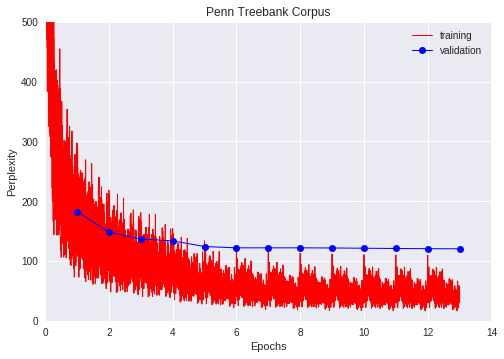

INFO:root:execution time - 0:06:48s



Loss/perplexity on test set after 13 epochs:     4.74/  114.29



In [7]:
#MIT License - Copyright (c) 2018 tmatha
#*******************************************************************************
# ---------------------- set up -----------------------------------------------*
#                                                                              *
#*******************************************************************************
start_time=time.time()
logging.basicConfig(level=logging.INFO)
logging.info('date {}'.format(datetime.datetime.now()))
logging.info('device {}'.format(tf.test.gpu_device_name()))
logging.info('TensorFlow vers. {}'.format(tf.__version__))
assert tf.test.is_gpu_available()

#*******************************************************************************
# -------------- --- hyper parameters -----------------------------------------*
#                                                                              *
#*******************************************************************************
batch_size=20
seq_len=20
clip_norm=5
learning_rate=1.
decay=0.5
epochs=13
epochs_no_decay=4

#*******************************************************************************
# ---------------- data: Python lists of strings ------------------------------*
#                                                                              *
#*******************************************************************************
with open('ptb.train.txt','r') as f1,open('ptb.valid.txt','r') as f2,open(
    'ptb.test.txt','r') as f3:
    seq_train=f1.read().replace('\n','<eos>').split(' ')
    seq_valid=f2.read().replace('\n','<eos>').split(' ')
    seq_test=f3.read().replace('\n','<eos>').split(' ')

seq_train=list(filter(None,seq_train))
seq_valid=list(filter(None,seq_valid))
seq_test=list(filter(None,seq_test))

logging.info(seq_train[:10])
logging.info(seq_valid[:10])
logging.info(seq_test[:10])

size_train=len(seq_train)
size_valid=len(seq_valid)
size_test=len(seq_test)
logging.info('size_train {}, size_valid {}, size_test {}'.format(
    size_train,size_valid,size_test))

vocab_train=set(seq_train)
vocab_valid=set(seq_valid)
vocab_test=set(seq_test)

assert vocab_valid.issubset(vocab_train)
assert vocab_test.issubset(vocab_train)
logging.info('vocab_train {}, vocab_valid {}, vocab_test {}'.format(
    len(vocab_train),len(vocab_valid),len(vocab_test)))

vocab_train=sorted(vocab_train)#must have deterministic ordering, so word2id 
                               #dictionary is reproducible across invocations
word2id={w:i for i,w in enumerate(vocab_train)}
id2word={i:w for i,w in enumerate(vocab_train)}

#*******************************************************************************
# -- data: np.int64 1-d numpy arrays -> np.int64 2-d numpy arrays of shape ----*
# -- (seq_len*steps, batch_size) ----------------------------------------------*
#                                                                              *
#*******************************************************************************
#Note tf.contrib.cudnn_rnn.CudnnLSTM requires input tensor to be of shape 
#(seq_len,batch_size,embedding_dim), where as tf.keras.layers.CuDNNLSTM 
#requires input tensor to be of shape (batch_size,seq_len,embedding_dim)
ids_train=np.array([word2id[word] for word in seq_train],copy=False,order='C')
ids_valid=np.array([word2id[word] for word in seq_valid],copy=False,order='C')
ids_test=np.array([word2id[word] for word in seq_test],copy=False,order='C')

data_train,steps_train=features_labels(
    ids_train,batch_size,seq_len,batch_first=False)
data_valid,steps_valid=features_labels(
    ids_valid,batch_size,seq_len,batch_first=False)
data_test,steps_test=features_labels(
    ids_test,batch_size,seq_len,batch_first=False)

#*******************************************************************************
# ----------------- configure dataflow graph ----------------------------------*
#                                                                              *
#*******************************************************************************
#A model instance encapsulates all nodes (ops) and edges (tensors) of the 
#dataflow graph except:
#  features_placeholder: tf.int64 2-d tensor of shape (seq_len*steps,batch_size)
#  labels_placeholder:   tf.int64 2-d tensor of shape (seq_len*steps,batch_size)
#  lr: tf.float32 0-d tensor
#  learning_rate_decay: op to decay learning rate by a factor
tf.reset_default_graph()

features_placeholder=tf.placeholder(
    data_train.features.dtype, (None,batch_size))#data_train.features.shape
labels_placeholder=tf.placeholder(
    data_train.labels.dtype, (None,batch_size))#data_train.labels.shape
dataset=tf.data.Dataset.from_tensor_slices(
    (features_placeholder, labels_placeholder))
#"An initializable iterator requires you to run an explicit  
#iterator.initializer operation before using it. In exchange for this  
#inconvenience, it enables you to parameterize the definition of the dataset, 
#using one or more tf.placeholder() tensors that can be fed when you 
#initialize the iterator." - https://www.tensorflow.org/guide/datasets
iterator=dataset.batch(seq_len,drop_remainder=True).make_initializable_iterator()
features,labels=iterator.get_next()

lr=tf.get_variable('lr',initializer=learning_rate,trainable=False)
learning_rate_decay=lr.assign(lr*decay)

model=PTBModel.instance(model_type='small',
                        vocab_size=len(word2id),
                        clip_norm=clip_norm,
                        learning_rate=lr,
                        inp=features,
                        target=labels)

#kernels, biases, state and lr are tf.Variables
for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
  logging.info(var)

#*******************************************************************************
# ------------------------- initialize ----------------------------------------*
#                                                                              *
#*******************************************************************************
perplexity_train=[]
perplexity_valid=[]

print('\n'+' '*24+'TRAINING'+'\n'+
      'time'+' '*6+
      'epochs'+' '*9+
      'loss'+' '*15+
      'perplexity'+'\n'+
      ' '*20+
      'train'+' '*4+
      'valid'+' '*7+
      'train'+' '*7+
      'valid'+'\n'+
      '======'+' '*4+
      '======'+' '*4+
      '====='+' '*4+
      '====='+' '*7+
      '====='+' '*7+
      '=====')
  
session=tf.Session()
session.run(tf.initializers.global_variables())

#*******************************************************************************
# ---------------------- train and evaluate -----------------------------------*
#                                                                              *
#*******************************************************************************
for epoch in range(epochs):
  #train
  session.run(iterator.initializer,
              feed_dict={features_placeholder:data_train.features,
                         labels_placeholder:data_train.labels})
  losses_train=model.run_epoch(session,steps_train,is_training=True)
  assert len(losses_train)==steps_train
  loss_train_avg=sum(losses_train)/(len(losses_train)*seq_len*batch_size)
  perplexity_train+=[(epoch+(step+1)/len(losses_train),math.exp(loss/(
      seq_len*batch_size))) for step,loss in enumerate(losses_train)]
  
  #evaluate
  session.run(iterator.initializer,
              feed_dict={features_placeholder:data_valid.features,
                         labels_placeholder:data_valid.labels})
  losses_valid=model.run_epoch(session,steps_valid,is_training=False)
  assert len(losses_valid)==steps_valid
  loss_valid_avg=sum(losses_valid)/(len(losses_valid)*seq_len*batch_size)
  perplexity_valid.append((epoch+1,math.exp(loss_valid_avg)))
  
  if epoch>epochs_no_decay-2:
    session.run(learning_rate_decay)

  print('{:}'.format(datetime.timedelta(seconds=round(time.time()-start_time))),
        '{:5.2f}'.format(epoch+1),
        '{:5.2f}'.format(loss_train_avg),
        '{:5.2f}'.format(loss_valid_avg),
        '{:8.2f}'.format(math.exp(loss_train_avg)),
        '{:8.2f}'.format(perplexity_valid[-1][1]),sep=' '*4)

#*******************************************************************************
# ----------------------- plot ------------------------------------------------*
#                                                                              *
#*******************************************************************************
plt.plot([loss[0] for loss in perplexity_train],
         [loss[1] for loss in perplexity_train],
         linewidth=1,color='red',label='training')
plt.plot([loss[0] for loss in perplexity_valid],
         [loss[1] for loss in perplexity_valid],
         linewidth=1,color='blue',label='validation', marker='o')
plt.grid(True,which='both',axis='both')
plt.title('Penn Treebank Corpus')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.axis([0,14,0,500])
plt.legend()
plt.show()

#*******************************************************************************
# ------------------------ test -----------------------------------------------*
#                                                                              *
#*******************************************************************************
session.run(iterator.initializer,
            feed_dict={features_placeholder:data_test.features,
                       labels_placeholder:data_test.labels})
losses_test=model.run_epoch(session,steps_test,is_training=False)
assert len(losses_test)==steps_test
loss_test_avg=sum(losses_test)/(len(losses_test)*seq_len*batch_size)
print("\nLoss/perplexity on test set after {} epochs: {:8.2f}/{:8.2f}\n".format(
    epoch+1,loss_test_avg,math.exp(loss_test_avg)))

#*******************************************************************************
# ----------------------- finish ----------------------------------------------*
#                                                                              *
#*******************************************************************************
session.close()
logging.info("execution time - {}s".format(
    datetime.timedelta(seconds=round(time.time()-start_time))))